<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter13/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q https://www.dropbox.com/s/2xltmolfbfharri/apples_oranges.zip
!unzip -q apples_oranges.zip

In [ ]:
!pip install torch_snippets torch_summary
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary

     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 36.7MB 73kB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=70ea82871a70f9e33a0d9d17305dc45baed76439680be17043b0fcb03632425e
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars


In [ ]:
IMAGE_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
class CycleGANDataset(Dataset):
    def __init__(self, apples, oranges):
        self.apples = Glob(apples)
        self.oranges = Glob(oranges)

    def __getitem__(self, ix):
        apple = self.apples[ix % len(self.apples)]
        orange = choose(self.oranges)
        apple = Image.open(apple).convert('RGB')
        orange = Image.open(orange).convert('RGB')
        return apple, orange

    def __len__(self): return max(len(self.apples), len(self.oranges))
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch):
        srcs, trgs = list(zip(*batch))
        srcs = torch.cat([transform(img)[None] for img in srcs], 0).to(device).float()
        trgs = torch.cat([transform(img)[None] for img in trgs], 0).to(device).float()
        return srcs.to(device), trgs.to(device)

In [ ]:
trn_ds = CycleGANDataset('apples_train', 'oranges_train')
val_ds = CycleGANDataset('apples_test', 'oranges_test')

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, collate_fn=val_ds.collate_fn)

2020-11-04 18:49:57.993 | INFO     | torch_snippets.loader:Glob:181 - 3067 files found at apples_train
2020-11-04 18:49:57.996 | INFO     | torch_snippets.loader:Glob:181 - 479 files found at oranges_train
2020-11-04 18:49:58.000 | INFO     | torch_snippets.loader:Glob:181 - 1021 files found at apples_test
2020-11-04 18:49:58.002 | INFO     | torch_snippets.loader:Glob:181 - 160 files found at oranges_test


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

In [ ]:
@torch.no_grad()
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()
    
    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

In [ ]:
def generator_train_step(Gs, optimizer, real_A, real_B):
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

In [ ]:
def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [ ]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

EPOCH: 0.000	loss_D: 1.495	loss_G: 12.493	loss_GAN: 1.655	loss_cycle: 0.734	loss_identity: 0.699	(0.88s - 27022.12s remaining)

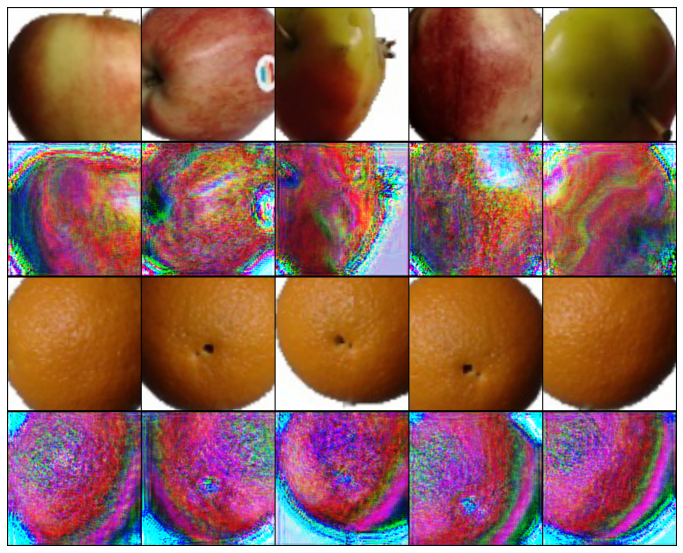

EPOCH: 0.033	loss_D: 0.493	loss_G: 2.204	loss_GAN: 0.857	loss_cycle: 0.099	loss_identity: 0.071	(69.10s - 20913.16s remaining)

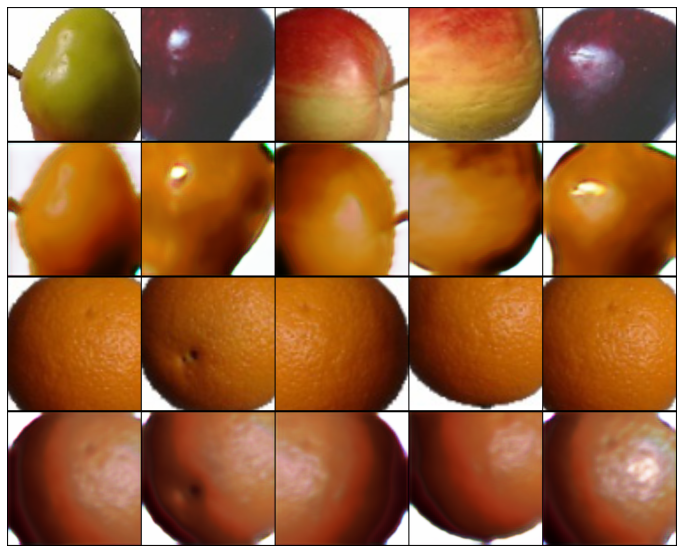

EPOCH: 0.066	loss_D: 0.283	loss_G: 2.625	loss_GAN: 0.505	loss_cycle: 0.153	loss_identity: 0.118	(140.12s - 21240.59s remaining)

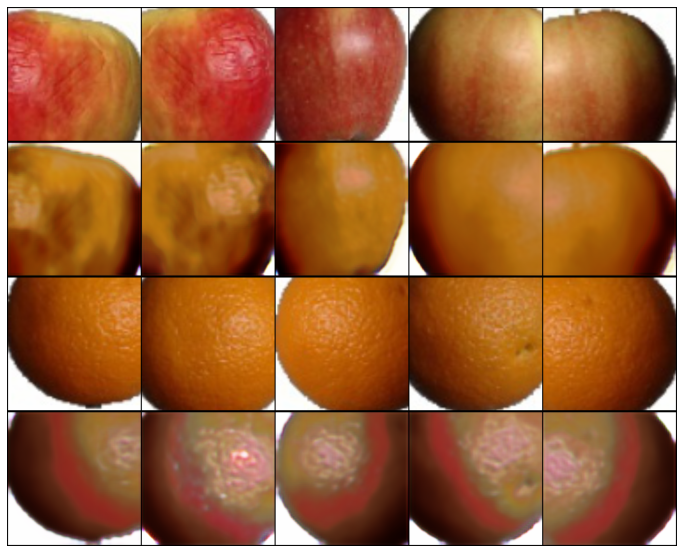

EPOCH: 0.098	loss_D: 0.215	loss_G: 2.611	loss_GAN: 0.334	loss_cycle: 0.155	loss_identity: 0.146	(211.07s - 21295.81s remaining)

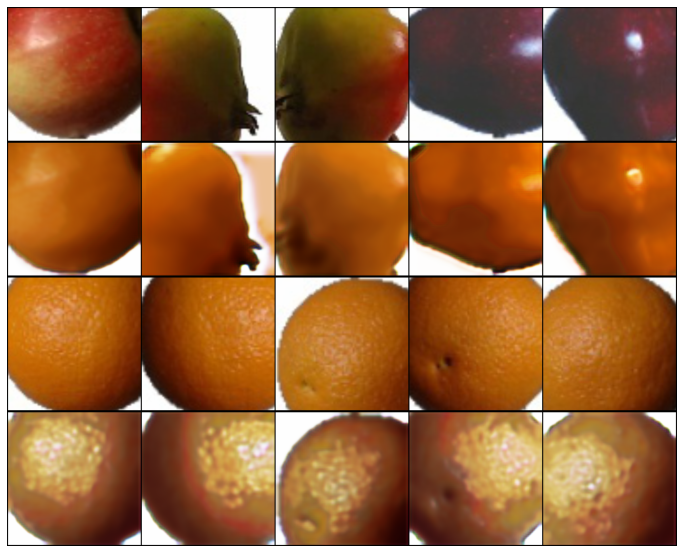

EPOCH: 0.131	loss_D: 0.184	loss_G: 1.951	loss_GAN: 0.430	loss_cycle: 0.109	loss_identity: 0.085	(281.95s - 21282.65s remaining)

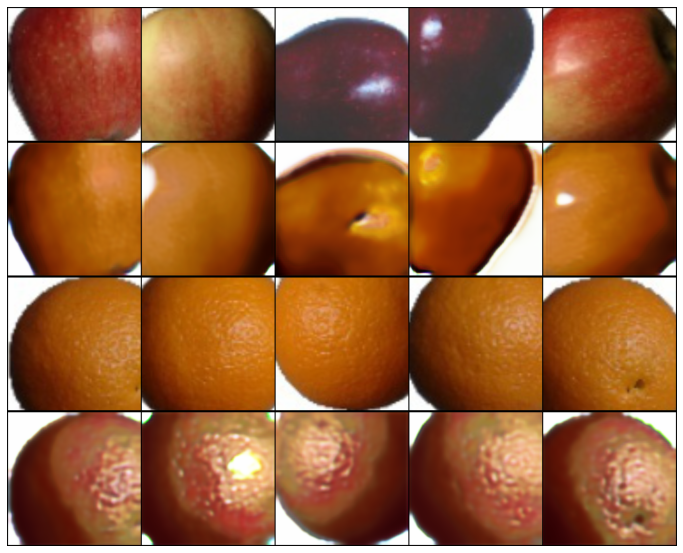

EPOCH: 0.163	loss_D: 0.195	loss_G: 2.200	loss_GAN: 0.385	loss_cycle: 0.121	loss_identity: 0.120	(352.70s - 21238.79s remaining)

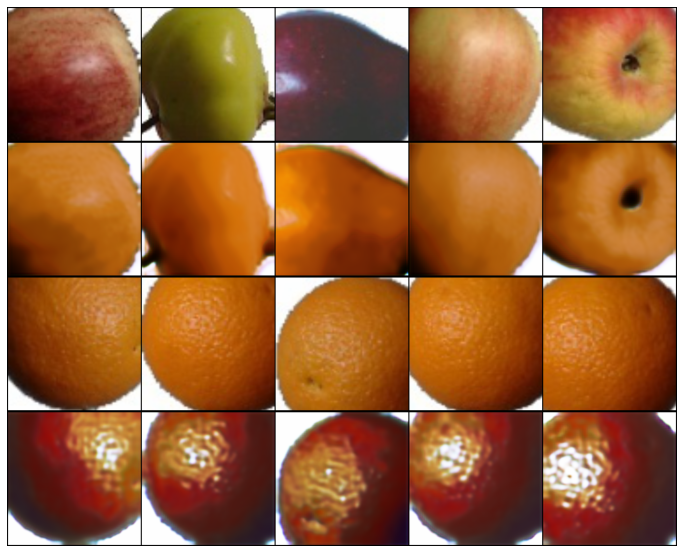

EPOCH: 0.167	loss_D: 0.463	loss_G: 2.237	loss_GAN: 0.551	loss_cycle: 0.117	loss_identity: 0.103	(360.50s - 21276.61s remaining)

In [ ]:
n_epochs = 10
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2
        
        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(), 
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(), 
                   loss_identity=loss_identity.item(), end='\r')
        if bx%100==0: generate_sample()

    log.report_avgs(epoch+1)